In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import scipy
from tqdm import tqdm

import lib

In [2]:
video_path = 'inputs/PXL_20241220_231952124.mp4'
desired_fps = 7
bar_height = 50

In [3]:
imgs = lib.sample_video(video_path, desired_fps)
im_background = lib.calculate_background(imgs)

In [4]:
bar_height = 26
im = imgs[0]

im = lib.resize(im)
im = lib.auto_rotate(im)
im = lib.remove_background(im, im_background)

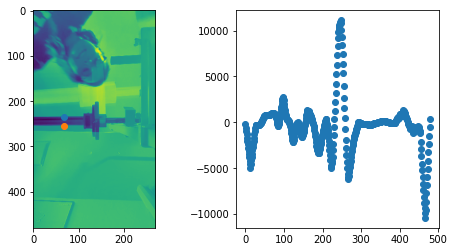

In [5]:
correlation, bar_ind_y_top, bar_ind_y_bottom, bar_ind_x, bar_height = lib.get_features_minimal(im, bar_height)

lib.plot_frame_minimal(im, correlation, bar_ind_y_top, bar_ind_y_bottom, bar_ind_x)

In [7]:
bar_height_guess=24
bar_heights = []
for im in tqdm(imgs):
  im = lib.resize(im)
  im = lib.auto_rotate(im)
  im = lib.remove_background(im, im_background)
  correlation, bar_ind_y_top, bar_ind_y_bottom, bar_ind_x, bar_height = lib.get_features_minimal(im, bar_height_guess)
  #if np.abs(bar_height-bar_height_new)< 5:
  #  bar_height = bar_height_new

  bar_heights.append(bar_height)

100%|██████████| 247/247 [00:00<00:00, 990.12it/s]


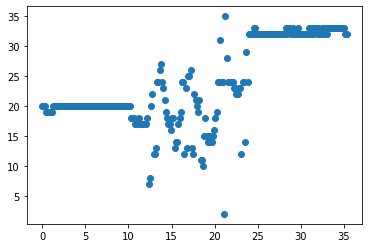

In [8]:
duration = len(imgs)/desired_fps
t = np.linspace(0, duration, len(bar_heights))

plt.scatter(t, bar_heights)

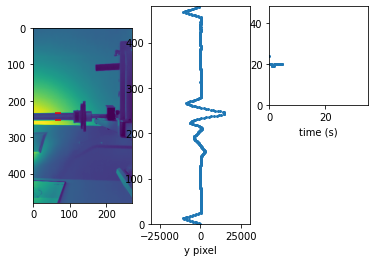

In [54]:
bar_height_guess=24

fig = plt.figure()

ax1 = plt.subplot(1, 3, 1)
ax1_im = ax1.imshow(im_background, cmap='viridis')
ax1_plt = ax1.scatter(0, 0, c='r', marker='_')

ax2 = plt.subplot(2, 3, 3)
ax2_plt = ax2.scatter(0, 0, s=4)#t, bar_heights, s=4)
plt.xlim([0, len(imgs)/desired_fps])
plt.ylim([0, bar_height_guess*2])
plt.xlabel('time (s)')

ax3 = plt.subplot(1, 3, 2)
ax3_plt = ax3.scatter(0, 0, s=4)#t, bar_heights, s=4)

plt.xlim([-bar_height_guess*255*5, bar_height_guess*255*5])
plt.xlabel('y pixel')

#ax2_plt = ax2.axvline(x=0, color='red', linestyle='--') 
ts = [0]
bar_heights = [bar_height_guess]

def animate(i):
  global ts, desired_fps, bar_heights
  im = imgs[i]
  im = lib.resize(im)
  im = lib.auto_rotate(im)
  ax1_im.set_data(im)
  im = lib.remove_background(im, im_background)
  
  correlation, bar_ind_y_top, bar_ind_y_bottom, bar_ind_x, bar_height = lib.get_features_minimal(im, bar_height_guess)
  bar_ind_y = bar_ind_y_top, bar_ind_y_bottom
  ax1_plt.set_offsets(np.c_[[bar_ind_x, bar_ind_x], bar_ind_y])

  bar_heights.append(bar_height)
  ts.append(ts[-1]+1/desired_fps)
  ax2_plt.set_offsets(np.c_[ts, bar_heights])

  ax3_plt.set_offsets(np.c_[correlation, np.arange(len(correlation))])
  plt.gca().set_ylim([0, len(correlation)])


  return [ax1_im, ax1_plt, ax2_plt, ax3_plt]

ani = animation.FuncAnimation(fig, animate, frames=len(imgs[:30]), interval=1/desired_fps*1000, blit=True)
ani.save('animation.mp4')

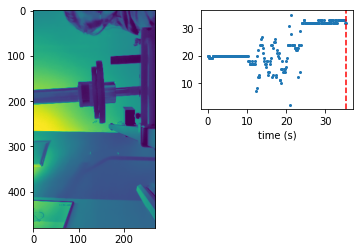

In [11]:
ax2 = plt.subplot(2, 2, 2)
plt.scatter(t, bar_heights, s=4)
plt.xlabel('time (s)')
ax2_plt = ax2.axvline(x=0, color='red', linestyle='--') 

def animate(i): 
  ax1_im.set_data(imgs[i])
  ax2_plt.set_xdata(t[i]) 
  return [ax1_im, ax2_plt]


ani = animation.FuncAnimation(fig, animate, frames=len(imgs), interval=1/desired_fps*1000, blit=True)
ani.save('animation.mp4')